In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Cargo el dataset
csv_path = 'data/Mall_Customers.csv'  
df = pd.read_csv(csv_path)
df.head(5)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [4]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [5]:
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [6]:
df['Gender'].nunique()

2

In [10]:
gender_counts = df['Gender'].value_counts()

# Crear lista de colores en el mismo orden que los índices
color_map = {"Male": "#1f77b4", "Female": "#ff7f0e"}
colors = [color_map[gender] for gender in gender_counts.index]


##  Visualización

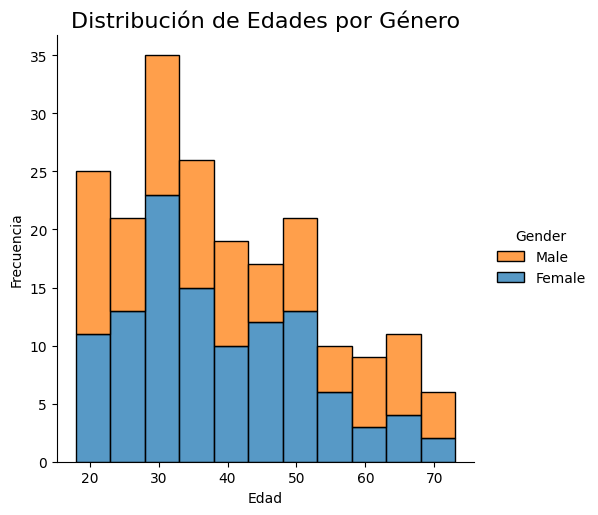

In [11]:
sns.displot(df, x="Age",binwidth=5, hue="Gender",palette = colors, multiple="stack")

plt.title("Distribución de Edades por Género", fontsize=16)
plt.xlabel("Edad", fontsize=10)
plt.ylabel("Frecuencia", fontsize=10)
plt.show()

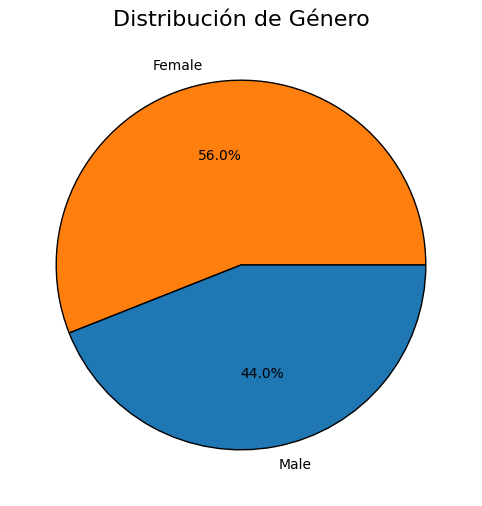

In [12]:
#Cuenta la cantidad de ocurrencias de cada valor único en la columna Gender
plt.figure(figsize=(8, 6))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', colors=colors,wedgeprops={'edgecolor': 'black', 'linewidth': 1.0})
plt.title("Distribución de Género", fontsize=16)
plt.show()

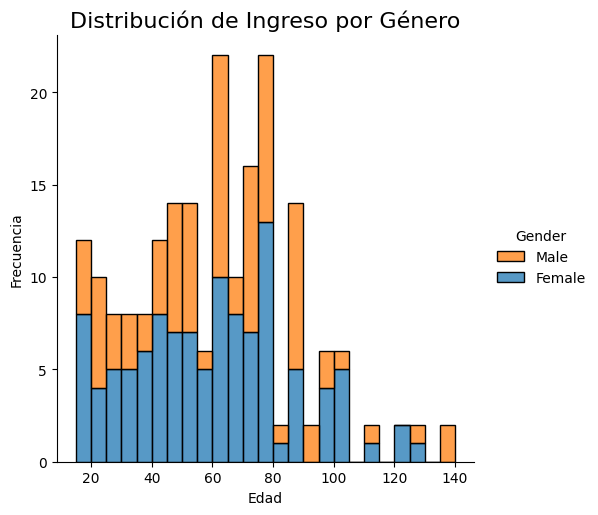

In [13]:
sns.displot(df, x="Annual Income (k$)",binwidth=5, hue="Gender",palette = colors, multiple="stack")

plt.title("Distribución de Ingreso por Género", fontsize=16)
plt.xlabel("Edad", fontsize=10)
plt.ylabel("Frecuencia", fontsize=10)
plt.show()

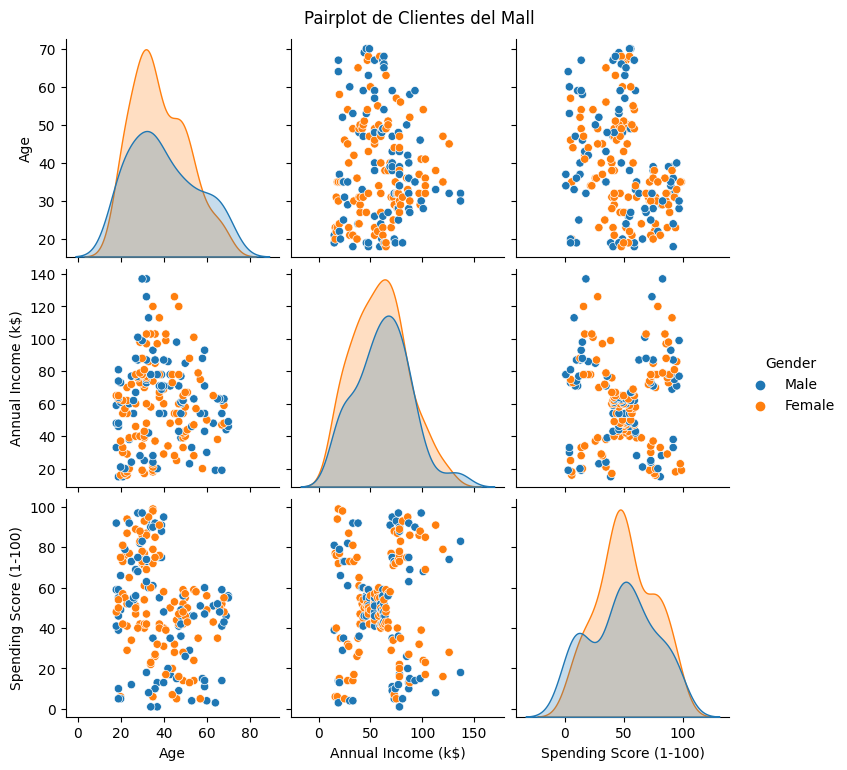

In [14]:
sns.pairplot(df.drop(columns=["CustomerID"]), hue="Gender")

# Mostrar el gráfico
plt.suptitle("Pairplot de Clientes del Mall", y=1.02)
plt.show()

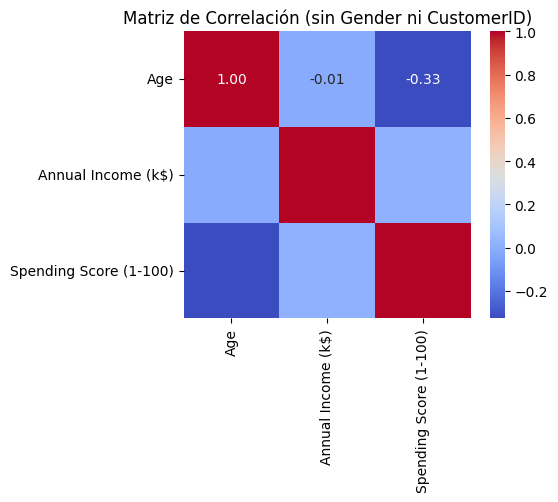

In [17]:
filtered_df = df.drop(columns=["CustomerID", "Gender"])

# Calcular la matriz de correlación solo con variables numéricas relevantes
corr_matrix_filtered = filtered_df.corr()

# Graficar la matriz de correlación limpia
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix_filtered, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matriz de Correlación (sin Gender ni CustomerID)")
plt.tight_layout()
plt.show()


### Resumen: 
1. Distribución por Género
La muestra tiene una distribución relativamente equilibrada entre hombres y mujeres. Esto permite hacer comparaciones válidas entre géneros sin sesgo de representación.
2. Edad
Hay una amplia variedad de edades entre los clientes. Se observa que las personas con menos de 50 años tienen un mayor gasto
3. Ingreso Anual vs Spending Score
No se detecta una correlación clara entre ingreso anual y nivel de gasto.
Esto refuerza la idea de que el ingreso no es el único factor que determina el comportamiento de compra.

# K-MEANS

In [18]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [24]:
clust_df = df.copy()
clust_df['Gender'] = [1 if i == "Female" else 0 for i in clust_df.Gender]

clust_df = clust_df.drop(columns=["CustomerID"])

# Normalizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(clust_df)

In [25]:
# Metodo del Elbow para determinar el número óptimo de clusters
import plotly.express as px

k_means = []
for clust in range(1, 16):
    km = KMeans(n_clusters=clust, init='k-means++', random_state=42, n_init=10)
    km.fit(X_scaled)
    k_means.append(pd.Series({'Clusters': clust, 'Inertia': km.inertia_, 'model': km}))


plot_km = pd.concat(k_means, axis=1).T[['Clusters', 'Inertia']].set_index('Clusters')

# 6. Gráfico interactivo con Plotly
fig = px.line(plot_km, x=plot_km.index, y='Inertia', markers=True,
              title="K-Means Clustering Elbow Curve (Normalizado)")
fig.update_traces(line_color='#518C89')

# Línea y anotación para k=5
fig.add_vline(x=5, line_width=3, line_dash="dash", line_color="darkgrey")
fig.add_annotation(
    x=5, y=plot_km.loc[5, 'Inertia'],
    text="Optimal Number of Clusters (k=5)",
    showarrow=True,
    arrowhead=2,
    ax=40, ay=-40,
    bgcolor='white',
    font=dict(size=12)
)

fig.update_layout(width=700, height=400)
fig.show()




In [26]:
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=42, n_init=10)
clust_df['Cluster'] = kmeans.fit_predict(X_scaled)

df_clustered = clust_df.copy()
df_clustered['Cluster'] = clust_df['Cluster']

# Promedios por grupo
cluster_summary = df_clustered.groupby('Cluster').mean().round(2)
print(cluster_summary)

         Gender    Age  Annual Income (k$)  Spending Score (1-100)
Cluster                                                           
0          0.54  32.69               86.54                   82.13
1          0.55  36.48               89.52                   18.00
2          1.00  49.81               49.23                   40.07
3          0.59  24.91               39.72                   61.20
4          0.00  55.71               53.69                   36.77


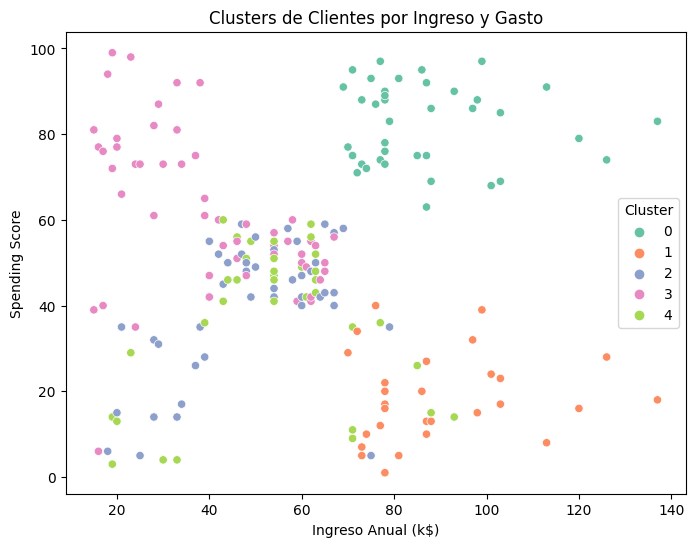

In [27]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=clust_df, x="Annual Income (k$)", y="Spending Score (1-100)", hue="Cluster", palette="Set2")
plt.title("Clusters de Clientes por Ingreso y Gasto")
plt.xlabel("Ingreso Anual (k$)")
plt.ylabel("Spending Score")
plt.legend(title="Cluster")
plt.show()